<a href="https://colab.research.google.com/github/lcipolina/Ray/blob/main/2_Ray_Tune_FeedFWD_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to add Ray Tuner to a Feed Forward in Pytorch

### Resources:
https://medium.com/mlearning-ai/training-feed-forward-neural-network-ffnn-on-gpu-beginners-guide-2d04254deca9

https://medium.com/analytics-vidhya/pytorch-for-deep-learning-feed-forward-neural-network-d24f5870c18

https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

In [19]:
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import sklearn

### Feed Forwards Big Picture

The five steps in the life-cycle are as follows:

    1. Prepare the Data.
    2. Define the Model.
    3. Train the Model.
    4. Evaluate the Model.
    5. Make Predictions

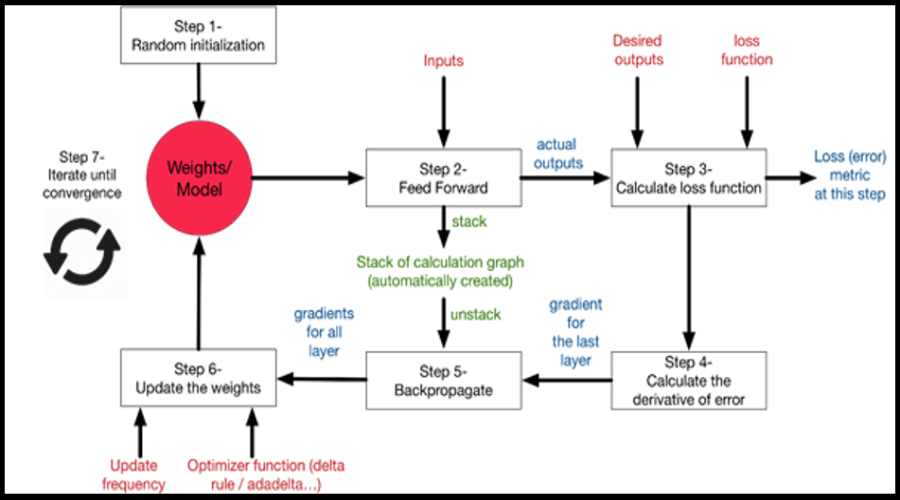

In [22]:
!curl -sS https://i.imgur.com/03jtoSi.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (900,500), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

## Data


In [45]:
#importing the 'diabetes' dataset
from sklearn.datasets import load_diabetes
data = load_diabetes()
x = data['data']
y = data['target']#shape
print('shape of x is : ',x.shape)
print('shape of y is : ',y.shape)

shape of x is :  (442, 10)
shape of y is :  (442,)


#### Data set and Data Loaders
  - Convert data to tensor
  - Return dimensions

In [48]:
#dataset
from torch.utils.data import Dataset, DataLoader
class diabetesdataset(Dataset):
  def __init__(self,x,y):   # Inherited from the parent class nn.Module
    self.x = torch.tensor(x,dtype=torch.float32) #transform to tensor
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]  

  def __getitem__(self,idx):
      return self.x[idx],self.y[idx]  

  def __len__(self):
      return self.length

dataset = diabetesdataset(x,y)

In [98]:
# Split into Training and Validation datasets
from torch.utils.data import random_split
torch.manual_seed(43)
val_size = 100 #change according to data shape

train_size       = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

DataLoader is used to perform mini batch or stochastic gradient descent by acting as an iterable

We use DataLoader class to shuffle data and separate it into batches that are feed to neural networks during each training step.

In [99]:
#dataloader 

batch_size=100 #batch size is a hyperparameter

def load_data(train_ds, val_ds,batch_size):
    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size*2)
    #test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True) #we have no test data for now

    return train_loader, val_loader

## Defining the Network
In PyTorch, neural networks are created by using Object Oriented Programming. 

The layers are defined in the init function and the forward pass is defined in the forward function, which is invoked automatically when the class is called.

These Functions are possible because of the class nn.Module from torch which was inherited.

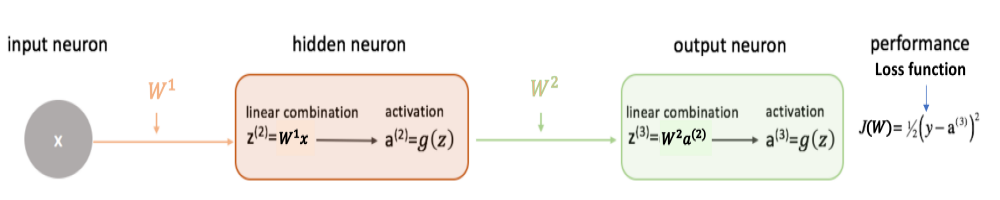

In [85]:
# Forward Propagation
!curl -sS https://i.imgur.com/E9IT9IH.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (1000,200), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

In [139]:
# Creating the network
from torch import nn

class Net(nn.Module):
  def __init__(self,input_size,hidden_nodes,output_size):  
    super(Net,self).__init__()                      # Inherited from the parent class nn.Module
    self.l1   = nn.Linear(input_size,hidden_nodes)  # 1st Full-Connected Layer: (input data) -> (hidden node)
    self.relu = nn.ReLU()                           # Non-Linear ReLU Layer: max(0,x)
    self.l2   = nn.Linear(hidden_nodes,output_size)            # 2nd Full-Connected Layer: (hidden node) -> 1 (output class)
    
  # Get predictions  
  def forward(self,x):                              # Forward pass: stacking each layer together
    output = self.l1(x) 
    output = self.relu(output)
    output = self.l2(output)
    return output

### Defining the Loss and Hyperparameters

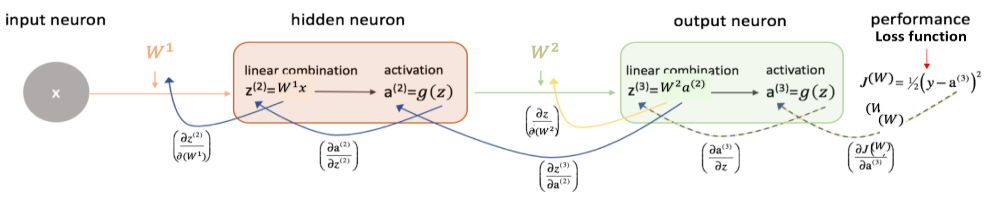

In [87]:
# Back Propagation
!curl -sS https://i.imgur.com/h0L2ier.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (1000,200), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

## Training

In [141]:
def train(model, loss_fn, optimizer,device, data = None):
  
    model.train()                                          # Sets model on training model (updates gradients)

    for xb,yb in data:                  #Load a batch 
        x_train, y_train = xb.to(device),  yb.to(device)    # GPU   
      

        y_pred = model(x_train) #calls the 'forward' method    # Forward pass: compute the output class given the features
        
        #calculating loss
        loss = criterion(y_pred,y_train.reshape(-1,1))         # Compute the loss: difference between the output class and the pre-given label
      
        #backprop
        optimizer.zero_grad()                                  # Intialize the hidden weight to all zeros
        loss.backward()                                        # Backward pass: compute the weight
        optimizer.step()                                       # Optimizer: update the weights of hidden nodes

  #Not needed with Ray
  #if j%5 == 0:  #prints every 5 epochs                     # Logging               
  #  print(cost)
  #  costval.append(loss)
    #%(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]


### Validation

In [143]:
def valid(model,loss_fn, device,data = None):    
        
    #### Runs this for every epoc ####        
    sum_batch_valid_loss = 0.0 #running loss
        
    model.eval() #set model to Evaluation mode
    with torch.no_grad():        
        for xb,yb in data:                  #Load a batch 
            x, y = xb.to(device),  yb.to(device)   #GPU        
            pred = model(x) 
            valid_step_loss = loss_fn(pred, y)

            sum_batch_valid_loss += valid_step_loss.item()*xb.size(0)
    
    return sum_batch_valid_loss

In [106]:
# Hyperparameters
epochs = 10
learning_rate = 0.01
hidden_size = 5

In [116]:
#input size = number of features , output size = 1 (one predicted value)
input_dim = x.shape[1]
output_dim = 1

10
5


### Model Specification and Train Wrapper

In [149]:
def trainFF(config,data = None):
   
    train_loader, val_loader = data
    
    #Model Configuration *************************************************************
    # Instatiate the class
    net = Net(input_dim, hidden_size, output_dim)

    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count()>1:
        net = nn.DataParallel(net) 
    net.to(device)

    # Loss Function and Optimizer
    criterion = nn.MSELoss()  #Mean Squared Loss because this is a regression problem
    
    
    # **** LR Decay (without momentum) *****
    optimizer = torch.optim.SGD(net.parameters(),lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9) #Multiplies the learning rate with gamma every step_size epochs. 
    #*****

  
    # **************************************************************************************
    #Run model for multiple epochs    
   
    for epoch in range(1,config['num_epochs']+1): 
    
        #print()
        #print('Epoch: {0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr'])) #track the epoch we are computing
        
        sum_batch_train_loss = train(net, criterion, optimizer, device, data = train_loader)
        sum_batch_valid_loss = valid(net, criterion,device, data = val_loader)      
        
        #avg_train_loss       = sum_batch_train_loss/train_size
        avg_valid_loss       = sum_batch_valid_loss/val_size
        
             
        scheduler.step()   #Optimize LR Based on Epochs
        
        # Send the current training result back to Tune
        tune.report(loss = float(avg_valid_loss), done=(epoch==config["num_epochs"]))
      
    tune.report(done=True)    
        
    
 
    return  # train_res_dict, net


## Run the model with Ray Tune

In [ ]:
!pip install ray[default] # -> Install here, otherwise it breakes the environment
!pip install ray torch torchvision
!pip install ray[tune]

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.progress_reporter import JupyterNotebookReporter

Trainer

In [151]:
import os
os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1"


config_dic= {
    "lr": tune.grid_search([ 0.1, 0.2]),  
    "num_epochs": 4,
    "batch_size": batch_size
}

    
data = load_data(train_ds, val_ds,config['batch_size'])


analysis = tune.run(
            tune.with_parameters(trainFF, data = data),          
            config = config_dic,
            verbose = 2,
            progress_reporter=JupyterNotebookReporter(overwrite=False)
            )
            

Trial trainFF_fba25_00000 reported loss=520382.78125 with parameters={'lr': 0.1, 'num_epochs': 4, 'batch_size': 100}.
Trial trainFF_fba25_00001 reported loss=727525.5625 with parameters={'lr': 0.2, 'num_epochs': 4, 'batch_size': 100}.
Trial trainFF_fba25_00000 reported loss=8427.779296875 with parameters={'lr': 0.1, 'num_epochs': 4, 'batch_size': 100}. This trial completed.
Trial trainFF_fba25_00001 reported loss=5938.5390625 with parameters={'lr': 0.2, 'num_epochs': 4, 'batch_size': 100}. This trial completed.


(pid=3401) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(pid=3401)   return F.mse_loss(input, target, reduction=self.reduction)
(pid=3402) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(pid=3402)   return F.mse_loss(input, target, reduction=self.reduction)


Trial name,status,loc,lr,iter,total time (s),loss
trainFF_fba25_00000,TERMINATED,,0.1,4,0.16338,8427.78
trainFF_fba25_00001,TERMINATED,,0.2,4,0.116045,5938.54


2021-08-11 04:31:27,596	INFO tune.py:550 -- Total run time: 4.55 seconds (4.40 seconds for the tuning loop).


### Analyze Results

In [152]:
variable_trailed = "loss" #this should be a string
print("Best config: ", analysis.get_best_config(
    metric = variable_trailed, mode="min"))

Best config:  {'lr': 0.2, 'num_epochs': 4, 'batch_size': 100}


In [153]:
vble_trailed = loss #this is a column name

# Get a dataframe for analyzing trial results.
df = analysis.results_df

#Plot the performance of this trial
dfs = analysis.fetch_trial_dataframes()
[d.vble_trailed.plot() for d in dfs.values()]
plt.xlabel("epoch"); plt.ylabel("Test Accuracy"); 

AttributeError: ignored

### Save the trained FNN Model for future use

In [95]:
torch.save(model.state_dict(), ‘fnn_model.pkl’)

SyntaxError: ignored